# Import the datasets

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
% matplotlib inline
plt.style.use('seaborn-whitegrid')

TRAIN_PATH = '../input/train.csv'
TEST_PATH = '../input/test.csv'

print(os.listdir("../input"))

['GCP-Coupons-Instructions.rtf', 'train.csv', 'sample_submission.csv', 'test.csv']


In [6]:
# For this plot and further analysis, we need a function to calculate the distance in miles between locations in lon,lat coordinates.
# This function is based on https://stackoverflow.com/questions/27928/
# calculate-distance-between-two-latitude-longitude-points-haversine-formula 
# return distance in miles

def add_time(df):
    # add time information
    df['year'] = df.pickup_datetime.apply(lambda t: t.year)
    df['weekday'] = df.pickup_datetime.apply(lambda t: t.weekday())
    df['hour'] = df.pickup_datetime.apply(lambda t: t.hour)
    
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a)) # 2*R*asin...

def add_travel_vector_features(df):
    # add new column to dataframe with distance in miles
    df['distance_miles'] = distance(df.pickup_latitude, df.pickup_longitude, \
                                          df.dropoff_latitude, df.dropoff_longitude)
    #df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    #df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()
    #df['abs_diff_lon_lat'] = (df.abs_diff_longitude + df.abs_diff_latitude)

def add_airport_dist(df):
    """
    Return minumum distance from pickup or dropoff coordinates to each airport.
    JFK: John F. Kennedy International Airport
    EWR: Newark Liberty International Airport
    LGA: LaGuardia Airport
    """
    jfk_coord = (40.639722, -73.778889)
    ewr_coord = (40.6925, -74.168611)
    lga_coord = (40.77725, -73.872611)
    
    pickup_lat = df['pickup_latitude']
    dropoff_lat = df['dropoff_latitude']
    pickup_lon = df['pickup_longitude']
    dropoff_lon = df['dropoff_longitude']
    
    pickup_jfk = distance(pickup_lat, pickup_lon, jfk_coord[0], jfk_coord[1]) 
    dropoff_jfk = distance(jfk_coord[0], jfk_coord[1], dropoff_lat, dropoff_lon) 
    pickup_ewr = distance(pickup_lat, pickup_lon, ewr_coord[0], ewr_coord[1])
    dropoff_ewr = distance(ewr_coord[0], ewr_coord[1], dropoff_lat, dropoff_lon) 
    pickup_lga = distance(pickup_lat, pickup_lon, lga_coord[0], lga_coord[1]) 
    dropoff_lga = distance(lga_coord[0], lga_coord[1], dropoff_lat, dropoff_lon) 
    
    df['jfk_dist'] = pd.concat([pickup_jfk, dropoff_jfk], axis=1).min(axis=1)
    df['ewr_dist'] = pd.concat([pickup_ewr, dropoff_ewr], axis=1).min(axis=1)
    df['lga_dist'] = pd.concat([pickup_lga, dropoff_lga], axis=1).min(axis=1)

def add_features(df):
    add_time(df)
    add_travel_vector_features(df)
    add_airport_dist(df)
    
    return df

def clean_df(df):
    print('Old size: %d' % len(df))
    
    # Remove observations with missing values
    df.dropna(how='any', axis='rows', inplace=True)

    # Removing observations with erroneous values
    mask = df['pickup_longitude'].between(-75, -73)
    mask &= df['dropoff_longitude'].between(-75, -73)
    mask &= df['pickup_latitude'].between(40, 42)
    mask &= df['dropoff_latitude'].between(40, 42)
    mask &= df['passenger_count'].between(0, 6)
    mask &= df['fare_amount'].between(0, 250)
    mask &= df['distance_miles'].between(0.05, 100)

    df = df[mask]
    
    print('New size: %d' % len(df))
    
    return df

In [5]:
%%time

df_train =  pd.read_csv(TRAIN_PATH, nrows = 10000000)
df_train['pickup_datetime'] = df_train['pickup_datetime'].str.slice(0, 16)
df_train['pickup_datetime'] = pd.to_datetime(df_train['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')

CPU times: user 28.6 s, sys: 3.5 s, total: 32.1 s
Wall time: 32.2 s


In [7]:
%%time

df_train = add_features(df_train)
df_train = clean_df(df_train)

Old size: 10000000
New size: 9632462
CPU times: user 48.8 s, sys: 10.8 s, total: 59.6 s
Wall time: 54.4 s


In [9]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import math

cols = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year', 'weekday', 'hour', 'distance_miles', 'jfk_dist', 'ewr_dist', 'lga_dist']
X = df_train[cols]
y = df_train['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01)

matrix_train = xgb.DMatrix(X_train,label=y_train)
matrix_test = xgb.DMatrix(X_test,label=y_test)

print(len(y_test))

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


96325


# Train XGB with default settings

In [11]:
%%time

params = {
    'objective':'reg:linear',
    'eval_metric':'rmse',
    'silent': 1,
    'nthread': 8,
    'n_jobs': 8,
}

model1 = xgb.train(
    params=params,
    dtrain=matrix_train,
    num_boost_round=1000,
    early_stopping_rounds=10,
    evals=[(matrix_test,'test')],
)

[0]	test-rmse:10.3121
Will train until test-rmse hasn't improved in 10 rounds.
[1]	test-rmse:7.6748
[2]	test-rmse:5.96108
[3]	test-rmse:4.88524
[4]	test-rmse:4.24624
[5]	test-rmse:3.87136
[6]	test-rmse:3.67096
[7]	test-rmse:3.55991
[8]	test-rmse:3.48222
[9]	test-rmse:3.44423
[10]	test-rmse:3.41113
[11]	test-rmse:3.38952
[12]	test-rmse:3.37698
[13]	test-rmse:3.3632
[14]	test-rmse:3.356
[15]	test-rmse:3.34975
[16]	test-rmse:3.34172
[17]	test-rmse:3.33651
[18]	test-rmse:3.32228
[19]	test-rmse:3.314
[20]	test-rmse:3.30656
[21]	test-rmse:3.3018
[22]	test-rmse:3.29549
[23]	test-rmse:3.28683
[24]	test-rmse:3.27771
[25]	test-rmse:3.27723
[26]	test-rmse:3.27357
[27]	test-rmse:3.27172
[28]	test-rmse:3.27101
[29]	test-rmse:3.26693
[30]	test-rmse:3.26156
[31]	test-rmse:3.25568
[32]	test-rmse:3.25348
[33]	test-rmse:3.25178
[34]	test-rmse:3.24808
[35]	test-rmse:3.24667
[36]	test-rmse:3.24142
[37]	test-rmse:3.22894
[38]	test-rmse:3.22665
[39]	test-rmse:3.22178
[40]	test-rmse:3.21887
[41]	test-rmse:3.

### Verify performance of training against validation set

In [12]:
y_pred_default = model1.predict(matrix_test, ntree_limit=model1.best_ntree_limit)
print('Score:', math.sqrt(mean_squared_error(y_test, y_pred_default)))

Score: 3.168346903265382


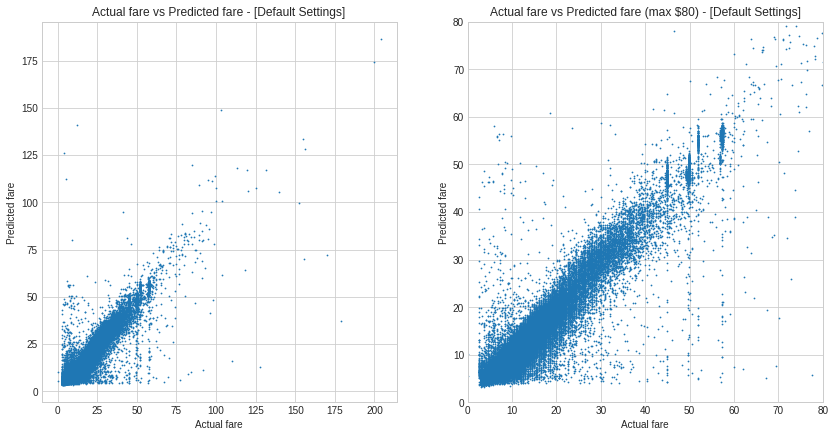

In [14]:
# plot prediction and actual data

plt.figure(figsize=(14,7))
plt.subplot(1, 2, 1)
plt.plot(y_test, y_pred_default, '.', markersize=1.5)
plt.title('Actual fare vs Predicted fare - [Default Settings]')
plt.xlabel('Actual fare')
plt.ylabel('Predicted fare')

plt.subplot(1, 2, 2)
plt.plot(y_test, y_pred_default, '.', markersize=1.5)
plt.title('Actual fare vs Predicted fare (max $80) - [Default Settings]')
plt.xlabel('Actual fare')
plt.ylabel('Predicted fare')
plt.xlim(0, 80)
plt.ylim(0, 80)

plt.show()

# Train XGB with tuned settings

In [15]:
%%time

params = {
    'objective':'reg:linear',
    'eval_metric':'rmse',
    #
    'max_depth': 7, #Result of tuning with CV
    'eta':.075, #Result of tuning with CV
    'subsample': 0.9, #Result of tuning with CV
    'colsample_bytree': 0.8, #Result of tuning with CV
    'colsample_bylevel': 0.6,
    'min_child_weight': 2,
    #
    'silent': 1,
    'nthread': 8,
    'n_jobs': 8,
}

model2 = xgb.train(
    params=params,
    dtrain=matrix_train,
    num_boost_round=1000,
    early_stopping_rounds=10,
    evals=[(matrix_test,'test')],
)

[0]	test-rmse:13.2527
Will train until test-rmse hasn't improved in 10 rounds.
[1]	test-rmse:12.3483
[2]	test-rmse:11.5136
[3]	test-rmse:10.7428
[4]	test-rmse:10.0478
[5]	test-rmse:9.39836
[6]	test-rmse:8.80373
[7]	test-rmse:8.25798
[8]	test-rmse:7.75624
[9]	test-rmse:7.29773
[10]	test-rmse:6.8822
[11]	test-rmse:6.50356
[12]	test-rmse:6.16173
[13]	test-rmse:5.87219
[14]	test-rmse:5.61437
[15]	test-rmse:5.35619
[16]	test-rmse:5.1405
[17]	test-rmse:4.9521
[18]	test-rmse:4.77204
[19]	test-rmse:4.60547
[20]	test-rmse:4.45312
[21]	test-rmse:4.33704
[22]	test-rmse:4.21615
[23]	test-rmse:4.12207
[24]	test-rmse:4.02662
[25]	test-rmse:3.94058
[26]	test-rmse:3.8668
[27]	test-rmse:3.80002
[28]	test-rmse:3.74833
[29]	test-rmse:3.69681
[30]	test-rmse:3.65193
[31]	test-rmse:3.61127
[32]	test-rmse:3.57812
[33]	test-rmse:3.54984
[34]	test-rmse:3.5219
[35]	test-rmse:3.49927
[36]	test-rmse:3.47883
[37]	test-rmse:3.46444
[38]	test-rmse:3.44806
[39]	test-rmse:3.43149
[40]	test-rmse:3.41849
[41]	test-rmse:

[346]	test-rmse:3.09293
[347]	test-rmse:3.0929
[348]	test-rmse:3.09312
[349]	test-rmse:3.09326
[350]	test-rmse:3.09312
[351]	test-rmse:3.09277
[352]	test-rmse:3.09248
[353]	test-rmse:3.09209
[354]	test-rmse:3.09181
[355]	test-rmse:3.09155
[356]	test-rmse:3.09127
[357]	test-rmse:3.09149
[358]	test-rmse:3.09148
[359]	test-rmse:3.09076
[360]	test-rmse:3.09074
[361]	test-rmse:3.09036
[362]	test-rmse:3.0903
[363]	test-rmse:3.09021
[364]	test-rmse:3.09032
[365]	test-rmse:3.09004
[366]	test-rmse:3.0898
[367]	test-rmse:3.08951
[368]	test-rmse:3.08937
[369]	test-rmse:3.08903
[370]	test-rmse:3.08872
[371]	test-rmse:3.0884
[372]	test-rmse:3.08832
[373]	test-rmse:3.08797
[374]	test-rmse:3.08776
[375]	test-rmse:3.08712
[376]	test-rmse:3.08703
[377]	test-rmse:3.08699
[378]	test-rmse:3.08693
[379]	test-rmse:3.08674
[380]	test-rmse:3.08642
[381]	test-rmse:3.08641
[382]	test-rmse:3.0865
[383]	test-rmse:3.08652
[384]	test-rmse:3.08655
[385]	test-rmse:3.08652
[386]	test-rmse:3.08643
[387]	test-rmse:3.086

### Verify performance of training against validation set

In [16]:
y_pred_tuned = model2.predict(matrix_test, ntree_limit=model2.best_ntree_limit)
print('Score:', math.sqrt(mean_squared_error(y_test, y_pred_tuned)))

Score: 3.0806732976540863


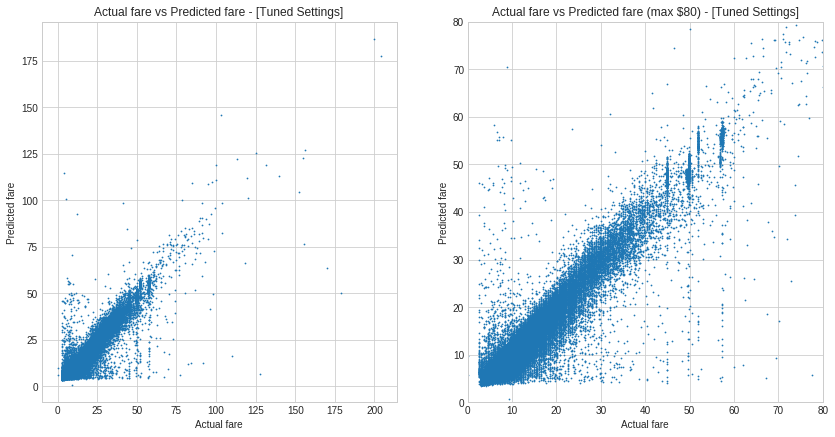

In [17]:
# plot prediction and actual data

plt.figure(figsize=(14,7))
plt.subplot(1, 2, 1)
plt.plot(y_test, y_pred_tuned, '.', markersize=1.5)
plt.title('Actual fare vs Predicted fare - [Tuned Settings]')
plt.xlabel('Actual fare')
plt.ylabel('Predicted fare')

plt.subplot(1, 2, 2)
plt.plot(y_test, y_pred_tuned, '.', markersize=1.5)
plt.title('Actual fare vs Predicted fare (max $80) - [Tuned Settings]')
plt.xlabel('Actual fare')
plt.ylabel('Predicted fare')
plt.xlim(0, 80)
plt.ylim(0, 80)

plt.show()

# Make predictions on the test set

In [18]:
df_test =  pd.read_csv(TEST_PATH)
df_test['pickup_datetime'] = df_test['pickup_datetime'].str.slice(0, 16)
df_test['pickup_datetime'] = pd.to_datetime(df_test['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')

add_features(df_test)

cols = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year', 'weekday', 'hour', 'distance_miles', 'jfk_dist', 'ewr_dist', 'lga_dist']
X_test = df_test[cols]

X_test.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,weekday,hour,distance_miles,jfk_dist,ewr_dist,lga_dist
0,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,13,1.443607,12.819377,10.424234,5.351000
1,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,13,1.507044,12.208516,9.455977,7.112463
2,-73.982524,40.751260,-73.979654,40.746139,1,2011,5,11,0.384398,12.832843,10.556347,6.000188
3,-73.981160,40.767807,-73.990448,40.751635,1,2012,5,21,1.218529,13.513499,10.184917,5.717171
4,-73.966046,40.789775,-73.988565,40.744427,1,2012,5,21,3.347514,13.152839,10.088114,4.964186


In [19]:
pred_test_default = model1.predict(xgb.DMatrix(X_test), ntree_limit = model1.best_ntree_limit)
pred_test_tuned = model2.predict(xgb.DMatrix(X_test), ntree_limit = model2.best_ntree_limit)

In [20]:
#Create submission file
submission_default = pd.DataFrame({
        "key": df_test['key'],
        "fare_amount": pred_test_default.round(2)
})

submission_tuned = pd.DataFrame({
        "key": df_test['key'],
        "fare_amount": pred_test_tuned.round(2)
})

submission_default = submission_default[['key', 'fare_amount']]
submission_tuned = submission_tuned[['key', 'fare_amount']]

submission_default.to_csv('taxi_fare_submission_default.csv',index=False)
submission_tuned.to_csv('taxi_fare_submission_tuned.csv',index=False)

In [21]:
submission_default.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.37
1,2015-01-27 13:08:24.0000003,11.50
2,2011-10-08 11:53:44.0000002,4.84
3,2012-12-01 21:12:12.0000002,7.75
4,2012-12-01 21:12:12.0000003,13.81


In [22]:
submission_tuned.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.75
1,2015-01-27 13:08:24.0000003,11.23
2,2011-10-08 11:53:44.0000002,4.31
3,2012-12-01 21:12:12.0000002,7.63
4,2012-12-01 21:12:12.0000003,13.68
